<a href="https://colab.research.google.com/github/amirAHS2000/cv_course/blob/master/fine_tuning_multilabel_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Fine-Tuning: Vision Transformers**
## **Multi-Label Image Classification**

In Multi-label classification each image in our dataset will have 1 or more than 1 class labels unlike multi-class classification where each image only has 1 label.

fine-tuning a Swin Transformer, specifically `swin_s3_base_224` from the [Hugging Face Timm](https://huggingface.co/docs/timm/index) library to obtain our pre-trained model.

For the dataset, we are going for [Pascal VOC 2007](http://host.robots.ox.ac.uk/pascal/VOC/voc2007/) dataset, which includes annotations for both multi-label classification and object detection.

we'll also be using [Hugging Face accelerate](https://huggingface.co/docs/accelerate/index) to power our training loops and for calculating metrics, we'll use [Hugging Face evaluate](https://huggingface.co/docs/evaluate/index)

Since we are using `accelerate`, it enables us to write loops that work in a distributed configuration as well automatically with support for Mixed-Precision, FSDP, DeepSpeed, etc. Although in this notebook, we'll keep it pretty simple.

#### importing the necessary modules and libraries

In [1]:
!pip install -Uq transformers datasets timm accelerate evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 70.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 56.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.9/330.9 kB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 68.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.0 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.transforms as T

from pathlib import Path
from PIL import Image

import datasets

from transformers.optimization import get_cosine_schedule_with_warmup

from timm import list_models, create_model

from accelerate import Accelerator, notebook_launcher

import evaluate

#### Downloading the dataset

In [3]:
dataset = datasets.load_dataset('fuliucansheng/pascal_voc','voc2007_main')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


pascal_voc.py:   0%|          | 0.00/15.2k [00:00<?, ?B/s]

The repository for fuliucansheng/pascal_voc contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/fuliucansheng/pascal_voc.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


voc2007.tar.gz:   0%|          | 0.00/878M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'image', 'height', 'width', 'classes', 'objects'],
        num_rows: 2501
    })
    validation: Dataset({
        features: ['id', 'image', 'height', 'width', 'classes', 'objects'],
        num_rows: 2510
    })
    test: Dataset({
        features: ['id', 'image', 'height', 'width', 'classes', 'objects'],
        num_rows: 4952
    })
})

**The dataset contains the following features:**

- id: unique id of the sample
- image: a `PIL.Image` format image.
- height: height of the image
- width: width of the image
- classes: a list of integer labels associated with the image
- objects: a dictionary of object bounding-box annotations.

we'll only be needing the `image` and the `classes` feature from the dataset.

Since in the dataset, the classes are given in integer format. We'll create two mappings, `label2id` and `id2label` to convert the labels to their IDs and vice versa. It will make it easy for us to understand the labels during visualization.

In [5]:
class_names = [
    "Aeroplane","Bicycle","Bird","Boat","Bottle",
    "Bus","Car","Cat","Chair","Cow","Diningtable",
    "Dog","Horse","Motorbike","Person",
    "Potted plant","Sheep","Sofa","Train","Tv/monitor"
]

In [6]:
label2id = {c:idx for idx,c in enumerate(class_names)}
id2label = {idx:c for idx,c in enumerate(class_names)}

#### look at some samples from the dataset

In [7]:
def show_samples(ds, rows, cols):
  samples = ds.shuffle().select(np.arange(rows*cols)) # selecting random images
  fig = plt.figure(figsize=(cols*4, rows*4))

  # plotting
  for i in range(rows*cols):
    img = samples[i]['image']
    labels = samples[i]['classes']
    # getting string labels and combining them with a comma
    labels = ','.join([id2label[lb] for lb in labels])
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(img)
    plt.title(labels)
    plt.axis('off')

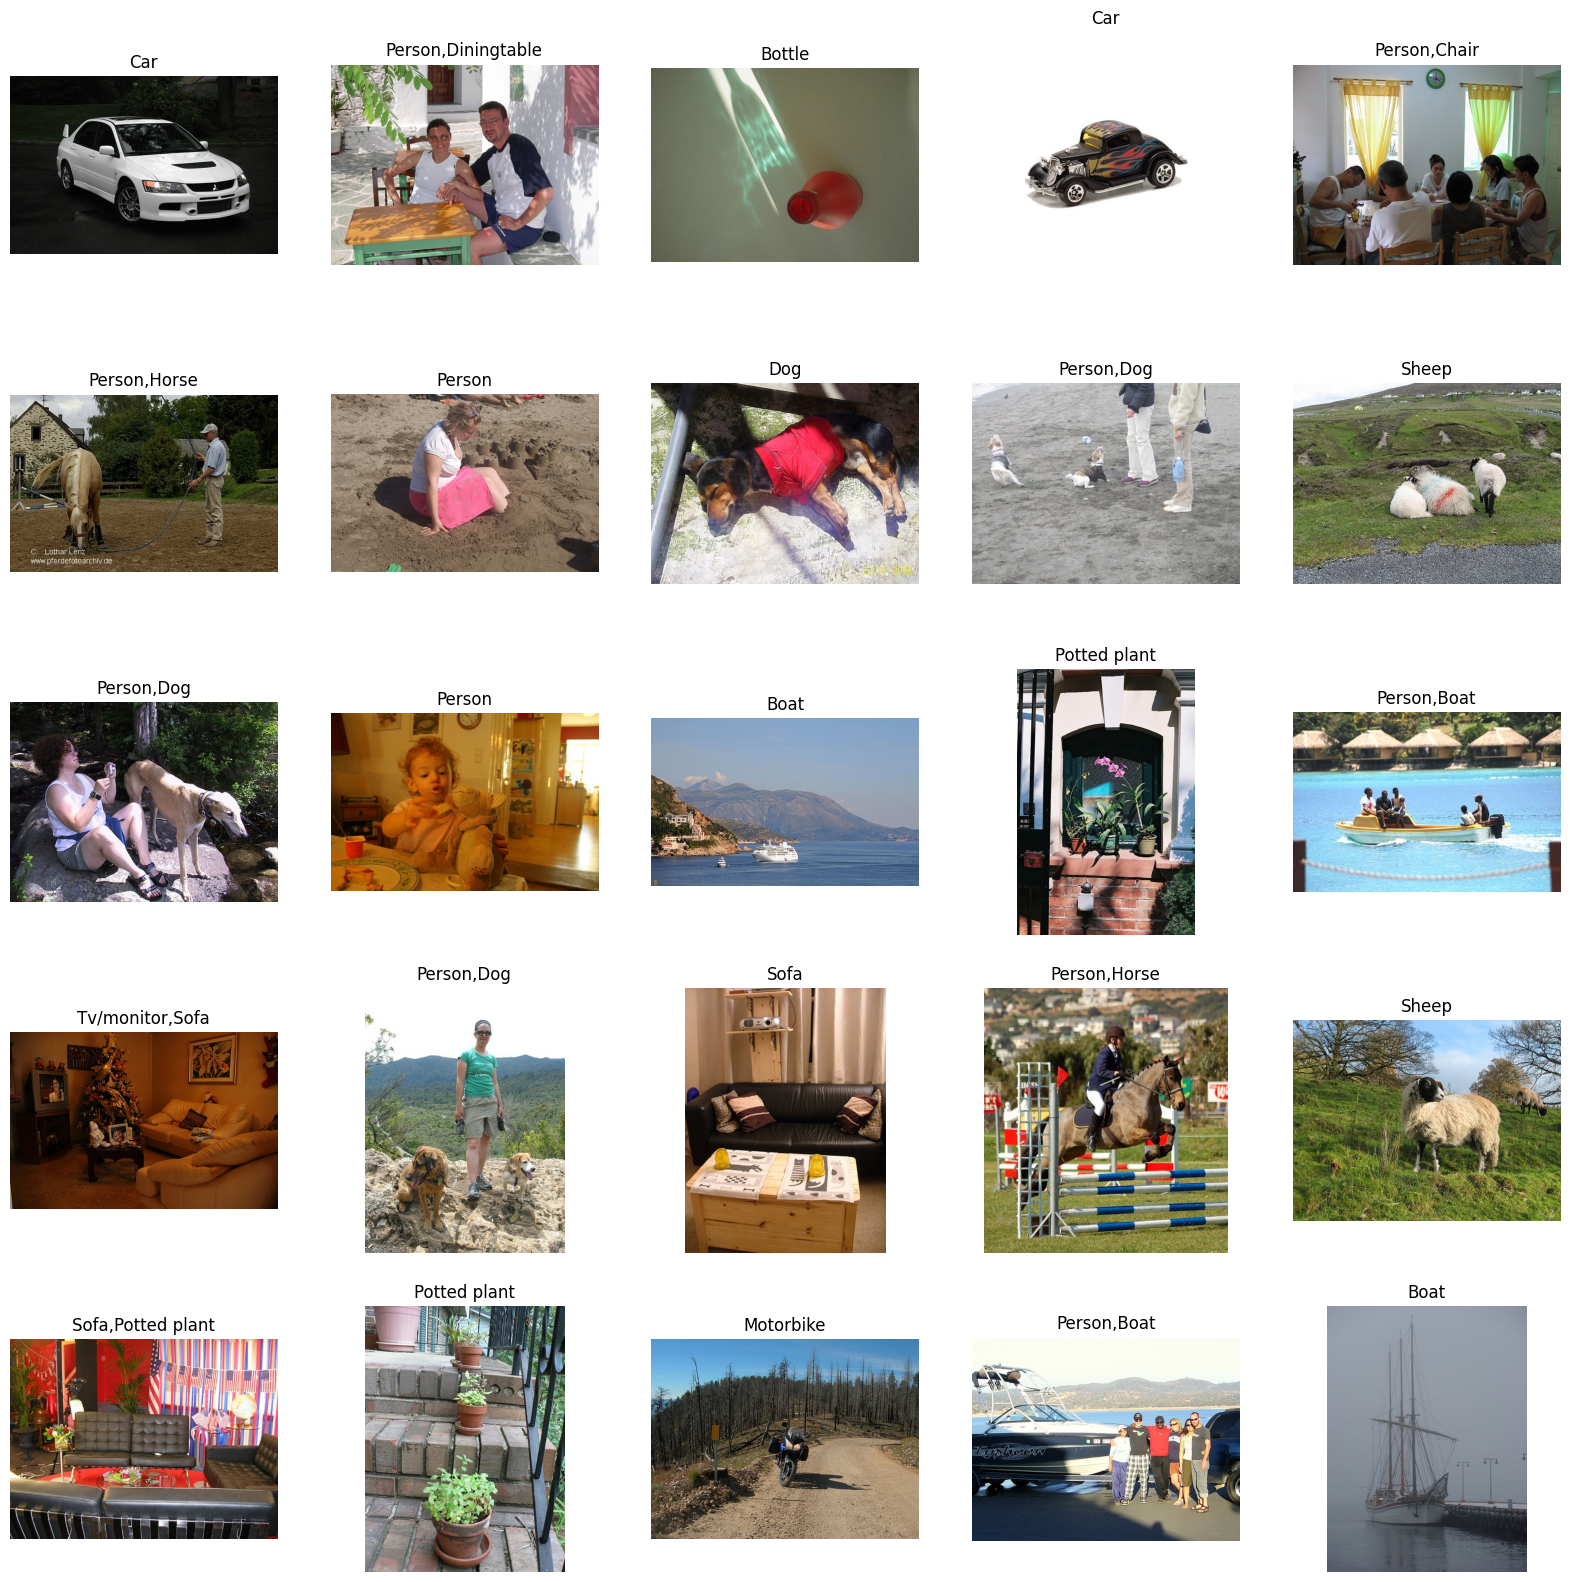

In [8]:
show_samples(dataset['train'], rows=5, cols=5)

#### Preprocessing out Dataset

### Image Transforms

This includes transforms such as resizing all images to have the same dimensions, normalizing, and scaling the pixel values to a uniform range. We can also add augmentations to our images like random flips, rotations, perspectives, etc.

For our transforms and augmentations, we'll be using [torchvision](https://pytorch.org/vision/stable/index.html).

Note: we apply random augmentations such as flips, rotations, etc. to our training dataset only. Hence we'll create two different transforms `train_tfms` for training and `valid_tfms` for validation and testing.

The transforms are as follows:
- Resize: The model name `swin_s3_base_224` indicates the image input size should be 224x224, so we'll resize accordingly.
- RandomHorizontalFlip: randomly flips samples horizontally.
- RandomRotation: rotates the images in a range, here (-30,+30) degrees.
- CenterCrop: crops about the center of the image
- ToTensor: converts the PIL image to a torch.Tensor with channels-first order and scales to [0,1] range.
- Normalize: normalizes the tensor with provided mean and std. For Vision Transformers, the general mean and std used is (0.5,0.5,0.5), so we'll go with that.

### Label Transforms

Since for each sample, we have multiple labels, we'll be using `one-hot encoding` which will transform our list of labels into a vector of 0s and 1s. The length of the vector will be equal to the number of labels and, at the index of the labels, the value will be 1 and remaining as 0s.

To do this in PyTorch, we'll be using `torch.nn.functional.one_hot` which works in the following manner:

When we pass a sample/batch to `train_transforms` or `valid_transforms` function. The `classes` will be in the form `[[3,5]]`, a list of sample labels. First we convert this list of lists into a tensor and then one-hot encode it.

When we apply this one-hot encoding, we are essentially converting this problem into a binary classification problem for each label.

In [9]:
img_size = (224, 224)

train_tfms = T.Compose([
    T.Resize(img_size),
    T.RandomHorizontalFlip(),
    T.RandomRotation(30),
    T.CenterCrop(img_size),
    T.ToTensor(),
    T.Normalize(
        mean=(0.5, 0.5, 0.5),
        std=(0.5, 0.5, 0.5)
    )
])

valid_tfms = T.Compose([
    T.Resize(img_size),
    T.ToTensor(),
    T.Normalize(
        mean=(0.5, 0.5, 0.5),
        std=(0.5, 0.5, 0.5)
    )
])

In [10]:
def train_transform(batch):
  # convert all images in batch to RGB to avoid grayscale or transparent images
  batch['image'] = [x.convert('RGB') for x in batch['image']]
  # apply torchvision.transform per sample in the batch
  inputs = [train_tfms(x) for x in batch['image']]
  batch['pixel_values'] = inputs

  # one-hot encoding the labels
  labels = torch.tensor(batch['classes'])
  batch['labels'] = nn.functional.one_hot(labels, num_classes=20).sum(dim=1)

  return batch

In [11]:
def valid_transforms(batch):
  # convert all images in batch to RGB to avoid grayscale or transparent images
  batch['image'] = [x.convert('RGB') for x in batch['image']]
  # apply torchvision.transfrom per sample in the batch
  inputs = [valid_tfms(x) for x in batch['image']]
  batch['pixel_values'] = inputs

  # one-hot encoding the labels
  labels = torch.tensor(batch['classes'])
  batch['labels'] = nn.functional.one_hot(labels, num_classes=20).sum(dim=1)

  return batch

We'll pair the preprocessing functions with our datasets using `with_transform` method.

In [12]:
train_dataset = dataset['train'].with_transform(train_transform)
valid_dataset = dataset['validation'].with_transform(valid_transforms)
test_dataset = dataset['test'].with_transform(valid_transforms)

len(train_dataset), len(valid_dataset), len(test_dataset)

(2501, 2510, 4952)

#### Data Collation

Batching our data in the correct format is collation. For `pixel_values`, the input shape for the model should be `(batch, channels, height, width)` and for our one-hot encoded `labels`, the shape should be `(batch,num_labels)`

In [13]:
def collate_fn(batch):
  return {
      'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
      'labels': torch.stack([x['labels'] for x in batch]).float()
  }

**A handy function to calculate the amount of trainable parameters in our model**

In [14]:
def params_count(model):
  params = [(p.numel(), p.requires_grad) for p in model.parameters()]
  trainable = sum([count for count, trainable in params if trainable])
  total = sum([count for count,_ in params])
  frac = (trainable / total) * 100

  return total, trainable, frac